In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import pickle

import cv2

from keras.datasets import cifar10
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import layers
from keras import models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

## Utility functions

In [3]:
def graph(history):
    epochs_range = range(1,len(history["loss"])+1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [4]:
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

## Loading the dataset

In [5]:
#load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, stratify = np.array(y_train), random_state=42)
#one hot encoding target variables
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print('x_train: ', x_train.shape, 'y_train: ', y_train.shape)
print('x_val: ', x_val.shape, 'y_val: ', y_val.shape)
print('x_test: ', x_test.shape, 'y_test: ', y_test.shape) 

x_train:  (42500, 32, 32, 3) y_train:  (42500, 10)
x_val:  (7500, 32, 32, 3) y_val:  (7500, 10)
x_test:  (10000, 32, 32, 3) y_test:  (10000, 10)


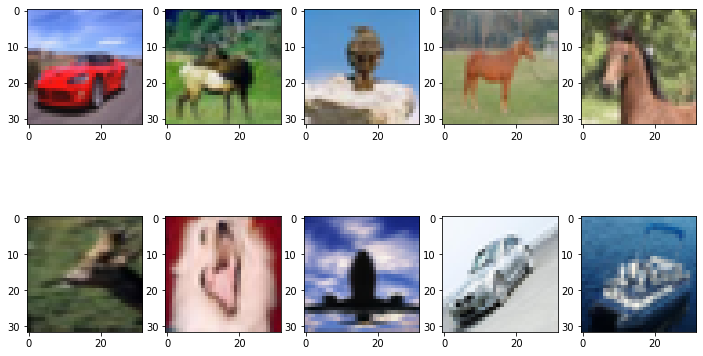

In [4]:
# plot first few images
fig = plt.figure(figsize=(12,7))
for i in range(10):
  # define subplot
	plt.subplot(2, 5, i+1)
	# plot raw pixel data
	plt.imshow(x_train[i])
# show the figure
plt.show()

## Preprocessing data

VGG16 takes input images having minimum of 48 pixels of height and width. Therefore resizing the images

In [6]:
def resize(images):
    img = np.zeros((images.shape[0],96,96,3),dtype=np.float32)
    for i in range(len(images)):
        img[i] = cv2.resize(images[i,:,:,:],(96,96))
    return img

In [7]:
x_train = resize(x_train)
x_val = resize(x_val)
x_test = resize(x_test)
print('x_train: ', x_train.shape, 'y_train: ', y_train.shape)
print('x_val: ', x_val.shape, 'y_val: ', y_val.shape)
print('x_test: ', x_test.shape, 'y_test: ', y_test.shape)

x_train:  (42500, 96, 96, 3) y_train:  (42500, 10)
x_val:  (7500, 96, 96, 3) y_val:  (7500, 10)
x_test:  (10000, 96, 96, 3) y_test:  (10000, 10)


## Setting Variables

In [40]:
batch_size= 256
epochs= 40
nb_classes= 10
learning_rate= 1e-5
size = x_train.shape[1:]

total_test = 10000
test_batch_size = 100

## Data Augmentation

In [9]:
train_data_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.15,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen.fit(x_train)
train_generator = train_data_gen.flow(x_train, y_train, batch_size=batch_size)

In [10]:
validation_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen.fit(x_val)
validation_generator = validation_data_gen.flow(x_val, y_val, batch_size=batch_size)

In [11]:
test_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen.fit(x_test)
test_generator = test_data_gen.flow(x_test, y_test, batch_size=test_batch_size)

## Preparing Model
Feature Extraction

Step 1 - Load pre-trained model and freeze

Step 2 - Create new model and add the frozen pretrained model in this model

Step 3 - Add dense layers

Step 4 - Train Model

In [12]:
vgg16 = VGG16(weights= 'imagenet', include_top= False, input_shape=size)

Load Pre-trained Model

We are select include_top = False to exclude dense layers.

This Model coming with trained weights on imagenet

In [13]:
#create new model and add pretrained model in this model
model = models.Sequential()
for i in range(len(vgg16.layers)):
    model.add(vgg16.layers[i])

for i in range(len(model.layers)): #freeze pretrained model
    model.layers[i].trainable = False

#add new layers your model
model.add(layers.Flatten())
model.add(layers.Dropout(0.40))
model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dense(nb_classes,activation="softmax"))

In [14]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 24, 24, 256)      

### Trainable parameters

In [19]:
(4608*256 + 256) + (256*10 + 10)

1182474

In [17]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=epochs,
                              verbose=1)

Epoch 1/1
167/167 [==============================] - 108s 644ms/step - loss: 1.5458 - acc: 0.4777 - val_loss: 1.1562 - val_acc: 0.6232


In [37]:
graph(history.history)

1328

In [39]:
save_history(history, 'history_sequential.bin')
model.save('pre_trained_vgg16_sequential.h5')

32

## Predictions

In [ ]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [ ]:
test_generator.reset()
prediction=model.predict_generator(test_generator,
                                   steps=total_test // test_batch_size,
                                   verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
100/100 [==============================] - 4s 43ms/step


In [ ]:
test_class_indices=np.argmax(y_test,axis=1)
labels = label_dict
test_labels = [labels[k] for k in test_class_indices]

In [ ]:
predicted_class_indices=np.argmax(prediction,axis=1)
labels = label_dict
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
results=pd.DataFrame({"Test Labels":test_labels,
                      "Predictions":predictions})
results.to_csv("results_pre_trained_vgg16_sequential.csv",index=False)

## Evaluate Model

In [ ]:
loss, acc = model.evaluate_generator(generator=validation_generator, steps=len(validation_generator))
print("Test Accuracy: ",acc)

[1.1409269571304321, 0.6746794581413269]

## **Fine Tuning**

Step 1 - Feature Extraction

Step 2 - Select layers to Fine Tunning

Step 3 - Train Model

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 24, 24, 256)      

In [36]:
#select after blocks block5_conv1 to fine tunnig
trainable = False
for i in model.layers:
    if i.name == "block5_conv1":
        trainable = True
    i.trainable = trainable

In [37]:
model.compile(optimizer=RMSprop(lr=learning_rate), loss="categorical_crossentropy",metrics=["acc"])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 24, 24, 256)      

In [ ]:
# history = model.fit_generator(generator=train_generator,
#                 steps_per_epoch=len(train_generator),epochs=epoch,
#                 validation_data=valid_generator,
#                 validation_steps=len(valid_generator))

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=epochs,
                              verbose=1)

In [ ]:
graph(history.history)

In [ ]:
save_history(history, 'history_sequential_fine_tune.bin') 
model.save('pre_trained_vgg16_sequential_fine_tune.h5')

## Evaluate Model

In [ ]:
loss, acc = model.evaluate_generator(generator=validation_generator, steps=len(validation_generator))
print("Test Accuracy: ",acc)

[1.1409269571304321, 0.6746794581413269]

## Predictions

In [ ]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [ ]:
test_generator.reset()
prediction=model.predict_generator(test_generator,
                                   steps=total_test // test_batch_size,
                                   verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
100/100 [==============================] - 4s 43ms/step


In [ ]:
test_class_indices=np.argmax(y_test,axis=1)
labels = label_dict
test_labels = [labels[k] for k in test_class_indices]

In [ ]:
predicted_class_indices=np.argmax(prediction,axis=1)
labels = label_dict
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
results=pd.DataFrame({"Test Labels":test_labels,
                      "Predictions":predictions})
results.to_csv("results_pre_trained_vgg16_sequential_fine_tune.csv",index=False)

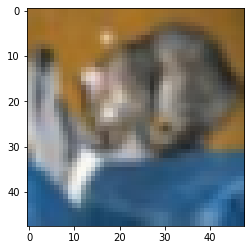

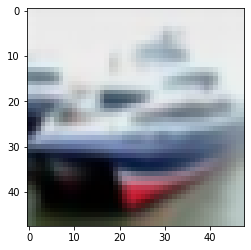

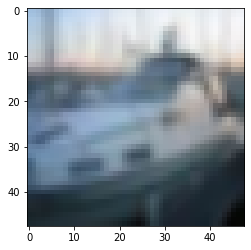

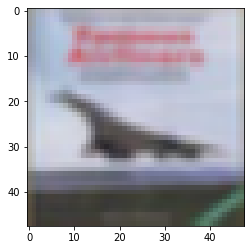

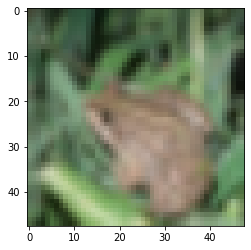

In [ ]:
for img in range(5):
  img_resized = resize(x_test[img],(48, 48),3)
  plt.imshow(img_resized)
  plt.show()